# Imports

In [1]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Set up arguments for datasets, models and training.

In [2]:
args = {
    "task" : "link_prediction",
    
    "dataset" : "IAEnronEmployees",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges",
    "mode" : "train",
    "generate_neg_examples" : True,
    
    "duplicate_examples" : True,
    "repeat_examples" : True,
    
    "self_loop" : False,
    "normalize_adj" : False,
    
    "cuda" : "True",
    "model" : "GraphSAGE",
    "agg_class" : "MaxPoolAggregator",
    "hidden_dims" : [64],
    "dropout" : 0.5,
    "num_samples" : -1,
    
    "epochs" : 3,
    "batch_size" : 32,
    "lr" : 1e-4,
    "weight_decay" : 5e-4,
    "stats_per_batch" : 3,
    "visdom" : True,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
config['device'] = device

# Get the dataset, dataloader and model.

In [3]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'train',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: train
Number of vertices: 151
Number of static edges: 759
Number of temporal edges: 15171
Number of examples/datapoints: 19960
--------------------------------


In [4]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()
config['input_dim'], config['output_dim'] = input_dim, output_dim

In [13]:
model = utils.get_model(config)
print(model)

GraphSAGE(
  (aggregators): ModuleList(
    (0): MaxPoolAggregator(
      (fc1): Linear(in_features=151, out_features=151, bias=True)
      (relu): ReLU()
    )
    (1): MaxPoolAggregator(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=302, out_features=64, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)


# Compute ROC-AUC score for the untrained model.

In [14]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset before training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset before training.
    Batch 1 / 776
    Batch 2 / 776
    Batch 3 / 776
    Batch 4 / 776
    Batch 5 / 776
    Batch 6 / 776
    Batch 7 / 776
    Batch 8 / 776
    Batch 9 / 776
    Batch 10 / 776
    Batch 11 / 776
    Batch 12 / 776
    Batch 13 / 776
    Batch 14 / 776
    Batch 15 / 776
    Batch 16 / 776
    Batch 17 / 776
    Batch 18 / 776
    Batch 19 / 776
    Batch 20 / 776
    Batch 21 / 776
    Batch 22 / 776
    Batch 23 / 776
    Batch 24 / 776
    Batch 25 / 776
    Batch 26 / 776
    Batch 27 / 776
    Batch 28 / 776
    Batch 29 / 776
    Batch 30 / 776
    Batch 31 / 776
    Batch 32 / 776
    Batch 33 / 776
    Batch 34 / 776
    Batch 35 / 776
    Batch 36 / 776
    Batch 37 / 776
    Batch 38 / 776
    Batch 39 / 776
    Batch 40 / 776
    Batch 41 / 776
    Batch 42 / 776
    Batch 43 / 776
    Batch 44 / 776
    Batch 45 / 776
    Batch 46 / 776
    Batch 47 / 776
    Batch 48 / 77

    Batch 417 / 776
    Batch 418 / 776
    Batch 419 / 776
    Batch 420 / 776
    Batch 421 / 776
    Batch 422 / 776
    Batch 423 / 776
    Batch 424 / 776
    Batch 425 / 776
    Batch 426 / 776
    Batch 427 / 776
    Batch 428 / 776
    Batch 429 / 776
    Batch 430 / 776
    Batch 431 / 776
    Batch 432 / 776
    Batch 433 / 776
    Batch 434 / 776
    Batch 435 / 776
    Batch 436 / 776
    Batch 437 / 776
    Batch 438 / 776
    Batch 439 / 776
    Batch 440 / 776
    Batch 441 / 776
    Batch 442 / 776
    Batch 443 / 776
    Batch 444 / 776
    Batch 445 / 776
    Batch 446 / 776
    Batch 447 / 776
    Batch 448 / 776
    Batch 449 / 776
    Batch 450 / 776
    Batch 451 / 776
    Batch 452 / 776
    Batch 453 / 776
    Batch 454 / 776
    Batch 455 / 776
    Batch 456 / 776
    Batch 457 / 776
    Batch 458 / 776
    Batch 459 / 776
    Batch 460 / 776
    Batch 461 / 776
    Batch 462 / 776
    Batch 463 / 776
    Batch 464 / 776
    Batch 465 / 776
    Batch 466 / 776


# Train.

In [15]:
if not config['load']:
    use_visdom = config['visdom']
    if use_visdom:
        vis = visdom.Visdom()
        loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.8)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 600, 1000, 1400], gamma=0.7)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                print('    Batch {} / {}: loss {:.4f}'.format(
                    idx+1, num_batches, running_loss))
                if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                    area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                    print('    ROC-AUC score: {:.4f}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if use_visdom:
                if loss_window is None:
                    loss_window = vis.line(
                        Y=[loss.item()],
                        X=[epoch*num_batches+idx],
                        opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
                else:
                    vis.line(
                        [loss.item()],
                        [epoch*num_batches+idx],
                        win=loss_window,
                        update='append')
            scheduler.step()
    if use_visdom:
        vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 3
    Batch 3 / 776: loss 0.6927
    ROC-AUC score: 0.4980
    Batch 6 / 776: loss 0.6931
    ROC-AUC score: 0.3927
    Batch 9 / 776: loss 0.6934
    ROC-AUC score: 0.4416
    Batch 12 / 776: loss 0.6931
    ROC-AUC score: 0.5556
    Batch 15 / 776: loss 0.6931
    ROC-AUC score: 0.4683
    Batch 18 / 776: loss 0.6928
    ROC-AUC score: 0.6310
    Batch 21 / 776: loss 0.6927
    ROC-AUC score: 0.4921
    Batch 24 / 776: loss 0.6930
    ROC-AUC score: 0.5843
    Batch 27 / 776: loss 0.6928
    ROC-AUC score: 0.6708
    Batch 30 / 776: loss 0.6923
    ROC-AUC score: 0.8672
    Batch 33 / 776: loss 0.6928
    ROC-AUC score: 0.6151
    Batch 36 / 776: loss 0.6917
    ROC-AUC score: 0.6277
    Batch 39 / 776: loss 0.6920
    ROC-AUC score: 0.7421
    Batch 42 / 776: loss 0.6930
    ROC-AUC score: 0.8340
    Batch 45 / 776: loss 0.6930
    ROC-AUC score: 0.6875
    Batch 48 / 776: loss 0.6914
    ROC-AUC score: 0.6923
    Batch 51 / 776: 

    Batch 420 / 776: loss 0.6782
    ROC-AUC score: 0.7500
    Batch 423 / 776: loss 0.6011
    ROC-AUC score: 0.8528
    Batch 426 / 776: loss 0.6199
    ROC-AUC score: 0.8510
    Batch 429 / 776: loss 0.6490
    ROC-AUC score: 0.7897
    Batch 432 / 776: loss 0.5812
    ROC-AUC score: 0.8083
    Batch 435 / 776: loss 0.6031
    ROC-AUC score: 0.8167
    Batch 438 / 776: loss 0.6090
    ROC-AUC score: 0.9028
    Batch 441 / 776: loss 0.6279
    ROC-AUC score: 0.8889
    Batch 444 / 776: loss 0.6546
    ROC-AUC score: 0.9412
    Batch 447 / 776: loss 0.5659
    ROC-AUC score: 0.9352
    Batch 450 / 776: loss 0.6204
    ROC-AUC score: 0.9414
    Batch 453 / 776: loss 0.6320
    ROC-AUC score: 0.7449
    Batch 456 / 776: loss 0.6462
    ROC-AUC score: 0.8314
    Batch 459 / 776: loss 0.6284
    ROC-AUC score: 0.8583
    Batch 462 / 776: loss 0.6343
    ROC-AUC score: 0.8275
    Batch 465 / 776: loss 0.5884
    ROC-AUC score: 0.9182
    Batch 468 / 776: loss 0.6050
    ROC-AUC score: 0.80

    Batch 66 / 776: loss 0.5945
    ROC-AUC score: 0.8849
    Batch 69 / 776: loss 0.5770
    ROC-AUC score: 0.8810
    Batch 72 / 776: loss 0.5675
    ROC-AUC score: 0.8118
    Batch 75 / 776: loss 0.6368
    ROC-AUC score: 0.8431
    Batch 78 / 776: loss 0.6023
    ROC-AUC score: 0.9957
    Batch 81 / 776: loss 0.5751
    ROC-AUC score: 0.9091
    Batch 84 / 776: loss 0.6070
    ROC-AUC score: 0.7765
    Batch 87 / 776: loss 0.5544
    ROC-AUC score: 0.7961
    Batch 90 / 776: loss 0.5780
    ROC-AUC score: 0.8863
    Batch 93 / 776: loss 0.6376
    ROC-AUC score: 0.8696
    Batch 96 / 776: loss 0.5539
    ROC-AUC score: 0.9271
    Batch 99 / 776: loss 0.5484
    ROC-AUC score: 0.9264
    Batch 102 / 776: loss 0.5980
    ROC-AUC score: 0.8254
    Batch 105 / 776: loss 0.5687
    ROC-AUC score: 0.8988
    Batch 108 / 776: loss 0.5247
    ROC-AUC score: 0.8532
    Batch 111 / 776: loss 0.6132
    ROC-AUC score: 0.9180
    Batch 114 / 776: loss 0.6657
    ROC-AUC score: 0.8442
    Batch

    Batch 486 / 776: loss 0.5537
    ROC-AUC score: 0.9610
    Batch 489 / 776: loss 0.5870
    ROC-AUC score: 0.9757
    Batch 492 / 776: loss 0.5404
    ROC-AUC score: 0.8929
    Batch 495 / 776: loss 0.5769
    ROC-AUC score: 0.9614
    Batch 498 / 776: loss 0.5594
    ROC-AUC score: 0.9648
    Batch 501 / 776: loss 0.5936
    ROC-AUC score: 0.8294
    Batch 504 / 776: loss 0.5514
    ROC-AUC score: 0.9137
    Batch 507 / 776: loss 0.5275
    ROC-AUC score: 0.8214
    Batch 510 / 776: loss 0.5450
    ROC-AUC score: 0.8941
    Batch 513 / 776: loss 0.5095
    ROC-AUC score: 0.9722
    Batch 516 / 776: loss 0.5691
    ROC-AUC score: 0.8392
    Batch 519 / 776: loss 0.5988
    ROC-AUC score: 0.8730
    Batch 522 / 776: loss 0.6228
    ROC-AUC score: 0.8902
    Batch 525 / 776: loss 0.5949
    ROC-AUC score: 0.9008
    Batch 528 / 776: loss 0.5205
    ROC-AUC score: 0.8208
    Batch 531 / 776: loss 0.5977
    ROC-AUC score: 0.8784
    Batch 534 / 776: loss 0.5497
    ROC-AUC score: 0.88

    Batch 132 / 776: loss 0.5799
    ROC-AUC score: 0.7216
    Batch 135 / 776: loss 0.5372
    ROC-AUC score: 0.8588
    Batch 138 / 776: loss 0.5586
    ROC-AUC score: 0.7383
    Batch 141 / 776: loss 0.5792
    ROC-AUC score: 0.9325
    Batch 144 / 776: loss 0.5615
    ROC-AUC score: 0.8373
    Batch 147 / 776: loss 0.5477
    ROC-AUC score: 0.8988
    Batch 150 / 776: loss 0.5336
    ROC-AUC score: 0.9725
    Batch 153 / 776: loss 0.5963
    ROC-AUC score: 0.7897
    Batch 156 / 776: loss 0.5561
    ROC-AUC score: 0.9059
    Batch 159 / 776: loss 0.5538
    ROC-AUC score: 0.7576
    Batch 162 / 776: loss 0.5796
    ROC-AUC score: 0.9333
    Batch 165 / 776: loss 0.5475
    ROC-AUC score: 0.8314
    Batch 168 / 776: loss 0.5492
    ROC-AUC score: 0.9000
    Batch 171 / 776: loss 0.5153
    ROC-AUC score: 0.8196
    Batch 174 / 776: loss 0.6172
    ROC-AUC score: 0.8824
    Batch 177 / 776: loss 0.5898
    ROC-AUC score: 0.9286
    Batch 180 / 776: loss 0.5380
    ROC-AUC score: 0.88

    Batch 549 / 776: loss 0.5659
    ROC-AUC score: 0.8625
    Batch 552 / 776: loss 0.5227
    ROC-AUC score: 0.9206
    Batch 555 / 776: loss 0.5182
    ROC-AUC score: 0.7451
    Batch 558 / 776: loss 0.5462
    ROC-AUC score: 0.9490
    Batch 561 / 776: loss 0.5856
    ROC-AUC score: 0.8543
    Batch 564 / 776: loss 0.5326
    ROC-AUC score: 0.8078
    Batch 567 / 776: loss 0.5569
    ROC-AUC score: 0.9708
    Batch 570 / 776: loss 0.5246
    ROC-AUC score: 0.8730
    Batch 573 / 776: loss 0.5165
    ROC-AUC score: 0.9069
    Batch 576 / 776: loss 0.5179
    ROC-AUC score: 0.9437
    Batch 579 / 776: loss 0.5623
    ROC-AUC score: 0.8623
    Batch 582 / 776: loss 0.4944
    ROC-AUC score: 0.9412
    Batch 585 / 776: loss 0.5621
    ROC-AUC score: 0.7542
    Batch 588 / 776: loss 0.5259
    ROC-AUC score: 0.9643
    Batch 591 / 776: loss 0.5765
    ROC-AUC score: 0.8373
    Batch 594 / 776: loss 0.5773
    ROC-AUC score: 0.9333
    Batch 597 / 776: loss 0.5689
    ROC-AUC score: 0.86

In [16]:
if not config['load']:
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

# Compute ROC-AUC score after training.

In [17]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset after training.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {:.4f}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset after training.
    Batch 1 / 776
    Batch 2 / 776
    Batch 3 / 776
    Batch 4 / 776
    Batch 5 / 776
    Batch 6 / 776
    Batch 7 / 776
    Batch 8 / 776
    Batch 9 / 776
    Batch 10 / 776
    Batch 11 / 776
    Batch 12 / 776
    Batch 13 / 776
    Batch 14 / 776
    Batch 15 / 776
    Batch 16 / 776
    Batch 17 / 776
    Batch 18 / 776
    Batch 19 / 776
    Batch 20 / 776
    Batch 21 / 776
    Batch 22 / 776
    Batch 23 / 776
    Batch 24 / 776
    Batch 25 / 776
    Batch 26 / 776
    Batch 27 / 776
    Batch 28 / 776
    Batch 29 / 776
    Batch 30 / 776
    Batch 31 / 776
    Batch 32 / 776
    Batch 33 / 776
    Batch 34 / 776
    Batch 35 / 776
    Batch 36 / 776
    Batch 37 / 776
    Batch 38 / 776
    Batch 39 / 776
    Batch 40 / 776
    Batch 41 / 776
    Batch 42 / 776
    Batch 43 / 776
    Batch 44 / 776
    Batch 45 / 776
    Batch 46 / 776
    Batch 47 / 776
    Batch 48 / 776

    Batch 415 / 776
    Batch 416 / 776
    Batch 417 / 776
    Batch 418 / 776
    Batch 419 / 776
    Batch 420 / 776
    Batch 421 / 776
    Batch 422 / 776
    Batch 423 / 776
    Batch 424 / 776
    Batch 425 / 776
    Batch 426 / 776
    Batch 427 / 776
    Batch 428 / 776
    Batch 429 / 776
    Batch 430 / 776
    Batch 431 / 776
    Batch 432 / 776
    Batch 433 / 776
    Batch 434 / 776
    Batch 435 / 776
    Batch 436 / 776
    Batch 437 / 776
    Batch 438 / 776
    Batch 439 / 776
    Batch 440 / 776
    Batch 441 / 776
    Batch 442 / 776
    Batch 443 / 776
    Batch 444 / 776
    Batch 445 / 776
    Batch 446 / 776
    Batch 447 / 776
    Batch 448 / 776
    Batch 449 / 776
    Batch 450 / 776
    Batch 451 / 776
    Batch 452 / 776
    Batch 453 / 776
    Batch 454 / 776
    Batch 455 / 776
    Batch 456 / 776
    Batch 457 / 776
    Batch 458 / 776
    Batch 459 / 776
    Batch 460 / 776
    Batch 461 / 776
    Batch 462 / 776
    Batch 463 / 776
    Batch 464 / 776


# Plot the true positive rate and true negative rate vs threshold.

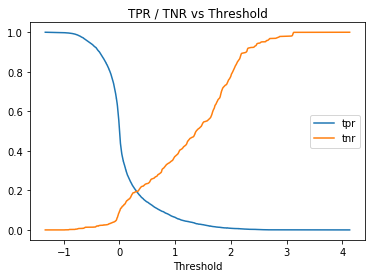

In [18]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

# Choose an appropriate threshold and generate classification report on the train set.

In [19]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('Threshold: {:.4f}, accuracy: {:.4f}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print('Classification report\n', report)

    Batch 1 / 776
    Batch 2 / 776
    Batch 3 / 776
    Batch 4 / 776
    Batch 5 / 776
    Batch 6 / 776
    Batch 7 / 776
    Batch 8 / 776
    Batch 9 / 776
    Batch 10 / 776
    Batch 11 / 776
    Batch 12 / 776
    Batch 13 / 776
    Batch 14 / 776
    Batch 15 / 776
    Batch 16 / 776
    Batch 17 / 776
    Batch 18 / 776
    Batch 19 / 776
    Batch 20 / 776
    Batch 21 / 776
    Batch 22 / 776
    Batch 23 / 776
    Batch 24 / 776
    Batch 25 / 776
    Batch 26 / 776
    Batch 27 / 776
    Batch 28 / 776
    Batch 29 / 776
    Batch 30 / 776
    Batch 31 / 776
    Batch 32 / 776
    Batch 33 / 776
    Batch 34 / 776
    Batch 35 / 776
    Batch 36 / 776
    Batch 37 / 776
    Batch 38 / 776
    Batch 39 / 776
    Batch 40 / 776
    Batch 41 / 776
    Batch 42 / 776
    Batch 43 / 776
    Batch 44 / 776
    Batch 45 / 776
    Batch 46 / 776
    Batch 47 / 776
    Batch 48 / 776
    Batch 49 / 776
    Batch 50 / 776
    Batch 51 / 776
    Batch 52 / 776
    Batch 53 / 776
  

    Batch 418 / 776
    Batch 419 / 776
    Batch 420 / 776
    Batch 421 / 776
    Batch 422 / 776
    Batch 423 / 776
    Batch 424 / 776
    Batch 425 / 776
    Batch 426 / 776
    Batch 427 / 776
    Batch 428 / 776
    Batch 429 / 776
    Batch 430 / 776
    Batch 431 / 776
    Batch 432 / 776
    Batch 433 / 776
    Batch 434 / 776
    Batch 435 / 776
    Batch 436 / 776
    Batch 437 / 776
    Batch 438 / 776
    Batch 439 / 776
    Batch 440 / 776
    Batch 441 / 776
    Batch 442 / 776
    Batch 443 / 776
    Batch 444 / 776
    Batch 445 / 776
    Batch 446 / 776
    Batch 447 / 776
    Batch 448 / 776
    Batch 449 / 776
    Batch 450 / 776
    Batch 451 / 776
    Batch 452 / 776
    Batch 453 / 776
    Batch 454 / 776
    Batch 455 / 776
    Batch 456 / 776
    Batch 457 / 776
    Batch 458 / 776
    Batch 459 / 776
    Batch 460 / 776
    Batch 461 / 776
    Batch 462 / 776
    Batch 463 / 776
    Batch 464 / 776
    Batch 465 / 776
    Batch 466 / 776
    Batch 467 / 776


# Evaluate on test set.

In [20]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['generate_neg_examples'], 'test',
                config['duplicate_examples'], config['repeat_examples'],
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Computing ROC-AUC score for the test dataset after training.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores, y_pred = [], [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    y_pred.extend(predictions.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        print('    Batch {} / {}: loss {:.4f}, accuracy {:.4f}'.format(
            idx+1, num_batches, running_loss, accuracy))
        if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
            area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
            print('    ROC-AUC score: {:.4f}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {:.4f}'.format(area))
print('Classification report\n', report)
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading dataset from /Users/raunak/Documents/Datasets/temporal-networks-network-repository/ia-enron-employees/ia-enron-employees.edges
Finished reading data.
Setting up graph.
Finished setting up graph.
Setting up examples.
Finished setting up examples.
Dataset properties:
Mode: test
Number of vertices: 151
Number of static edges: 1888
Number of temporal edges: 37929
Number of examples/datapoints: 24806
--------------------------------
--------------------------------
Computing ROC-AUC score for the test dataset after training.
    Batch 3 / 776: loss 0.6479, accuracy 0.7188
    ROC-AUC score: 0.8208
    Batch 6 / 776: loss 0.5329, accuracy 0.8438
    ROC-AUC score: 0.9167
    Batch 9 / 776: loss 0.5219, accuracy 0.8021
    ROC-AUC score: 0.7937
    Batch 12 / 776: loss 0.5243, accuracy 0.8125
    ROC-AUC score: 0.7814
    Batch 15 / 776: loss 0.5885, accuracy 0.7396
    ROC-AUC score: 0.8745
    Batch 18 / 776: loss 0.5657, accuracy 0.7500
    ROC-AUC 

    ROC-AUC score: 0.8980
    Batch 309 / 776: loss 0.4961, accuracy 0.8333
    ROC-AUC score: 0.8770
    Batch 312 / 776: loss 0.5082, accuracy 0.7917
    ROC-AUC score: 0.8353
    Batch 315 / 776: loss 0.5053, accuracy 0.8646
    ROC-AUC score: 0.9098
    Batch 318 / 776: loss 0.4924, accuracy 0.8750
    ROC-AUC score: 0.8571
    Batch 321 / 776: loss 0.5411, accuracy 0.8021
    ROC-AUC score: 0.7698
    Batch 324 / 776: loss 0.5561, accuracy 0.7604
    ROC-AUC score: 0.8413
    Batch 327 / 776: loss 0.5947, accuracy 0.7708
    ROC-AUC score: 0.8532
    Batch 330 / 776: loss 0.5272, accuracy 0.8333
    ROC-AUC score: 0.9312
    Batch 333 / 776: loss 0.5365, accuracy 0.7604
    ROC-AUC score: 0.8431
    Batch 336 / 776: loss 0.5530, accuracy 0.8021
    ROC-AUC score: 0.7852
    Batch 339 / 776: loss 0.5863, accuracy 0.7708
    ROC-AUC score: 0.9271
    Batch 342 / 776: loss 0.5494, accuracy 0.7917
    ROC-AUC score: 0.8118
    Batch 345 / 776: loss 0.5996, accuracy 0.7604
    ROC-AUC 

    Batch 633 / 776: loss 0.4776, accuracy 0.8750
    ROC-AUC score: 0.9375
    Batch 636 / 776: loss 0.5102, accuracy 0.8333
    ROC-AUC score: 0.9127
    Batch 639 / 776: loss 0.5013, accuracy 0.8125
    ROC-AUC score: 0.8157
    Batch 642 / 776: loss 0.5368, accuracy 0.8125
    ROC-AUC score: 0.9352
    Batch 645 / 776: loss 0.5668, accuracy 0.7812
    ROC-AUC score: 0.9167
    Batch 648 / 776: loss 0.5254, accuracy 0.8125
    ROC-AUC score: 0.8907
    Batch 651 / 776: loss 0.5210, accuracy 0.8021
    ROC-AUC score: 0.8254
    Batch 654 / 776: loss 0.5216, accuracy 0.8646
    ROC-AUC score: 0.9109
    Batch 657 / 776: loss 0.5815, accuracy 0.7812
    ROC-AUC score: 0.7188
    Batch 660 / 776: loss 0.5758, accuracy 0.7396
    ROC-AUC score: 0.8623
    Batch 663 / 776: loss 0.5639, accuracy 0.8542
    ROC-AUC score: 0.8611
    Batch 666 / 776: loss 0.5954, accuracy 0.7812
    ROC-AUC score: 0.8353
    Batch 669 / 776: loss 0.5389, accuracy 0.8021
    ROC-AUC score: 0.7835
    Batch 67